In [19]:
import cv2
import numpy as np
from PIL import Image
import os
import joblib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from xml.etree import ElementTree as et

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential                # creating sequential model of CNN
from keras.layers import Conv2D                    # creating convolution layer
from keras.layers import MaxPooling2D              # creating maxpool layer
from keras.layers import Flatten                   # creating input vector for dense layer
from keras.layers import Dense                     # create dense layer or fully connected layer
from keras.layers import Dropout                   # use to avoid overfitting by droping some params
from keras.layers import BatchNormalization        # for batch normalization
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# Utility functions

In [16]:
def extract_boxes(filename):
    '''This function can read the .xml file and output box coordinates and labels'''
    # load and parse the file
    tree = et.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    labels = []
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    for obj in root.findall('./object'):
        label = obj.find('name').text
        labels.append(label)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height, labels

# A quick example to see the images for training

In [39]:
boxes, width, height, labels = extract_boxes('train_zip/train/mixed_1.xml')
x_min,y_min,x_max,y_max = boxes[0]

In [40]:
x_min,y_min,x_max,y_max

(221, 83, 463, 338)

In [41]:
labels

['orange', 'apple', 'banana']

In [42]:
path = 'train_zip'
folder = 'train'
file = 'mixed_1.jpg'

# image_names.append(os.path.join(path, folder, file))
# data_labels.append(index)
img = load_img(os.path.join(path, folder, file), color_mode='rgb')
img = img_to_array(img)
print(img.shape)
y_scale = img.shape[0]/256
x_scale = img.shape[1]/256
img = load_img(os.path.join(path, folder, file), color_mode='rgb', target_size = (256,256))
img = img_to_array(img)


img_redo = scipy.ndimage.zoom(img, (y_scale, x_scale, 1), order=1)


(564, 800, 3)


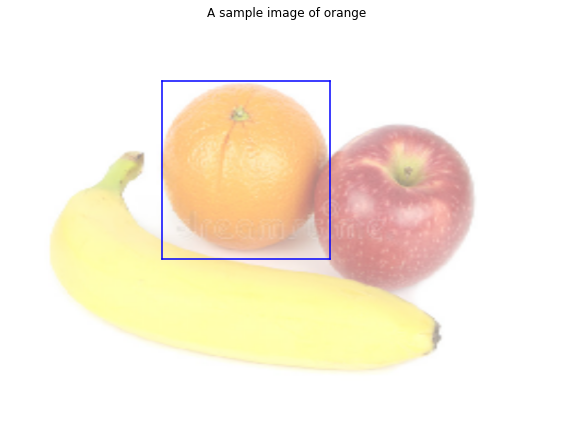

In [43]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img_redo.astype(np.uint8),alpha=0.5)
plt.plot([x_min,x_max], [y_min,y_min], [x_min,x_max], [y_max,y_max],[x_min,x_min], [y_min,y_max],[x_max,x_max], [y_min,y_max], color='blue')
plt.title('A sample image of {}'.format(labels[0]))
plt.axis('off')
plt.show()


# Read the images and paepare the `annotation.txt` 
- This part of the code is key to the data preparation
- We will read images and their .xml files for ground truth boxes coordinates
- Eventually we will save the information of image path, ground truth boxes coordinates, and class labels to the .txt file

In [132]:
train_path = 'train_zip/train'
train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
train_imgs = os.listdir('train_zip/train')
train_imgs = [name for name in train_imgs if name.endswith('.jpg')]


for name_img in train_imgs:
    name = name_img[:-4]+'.xml'
    boxes, width, height, labels = extract_boxes(os.path.join(train_path,name)) 
    if width==0 or height==0:
        img = load_img(os.path.join(train_path,name_img), color_mode='rgb')
        img = img_to_array(img)
        width = img.shape[1]
        height = img.shape[0]
        print(name)
    for index in range(len(boxes)):
        train_df = train_df.append({'FileName': name_img, 
                                            'XMin': boxes[index][0]/width, 
                                            'YMin': boxes[index][1]/height, 
                                            'XMax': boxes[index][2]/width, 
                                            'YMax': boxes[index][3]/height, 
                                            'ClassName': labels[index]}, 
                                           ignore_index=True)

apple_20.xml
apple_28.xml
apple_37.xml
apple_42.xml
apple_43.xml
apple_44.xml


C:\Users\schro\.conda\envs\TF\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


apple_8.xml
banana_25.xml
banana_35.xml
banana_53.xml
banana_57.xml
banana_60.xml
banana_71.xml
banana_72.xml
banana_75.xml
mixed_16.xml
orange_1.xml
orange_11.xml
orange_13.xml
orange_18.xml
orange_22.xml
orange_30.xml
orange_35.xml
orange_4.xml
orange_42.xml
orange_50.xml
orange_51.xml
orange_59.xml
orange_64.xml
orange_68.xml
orange_70.xml


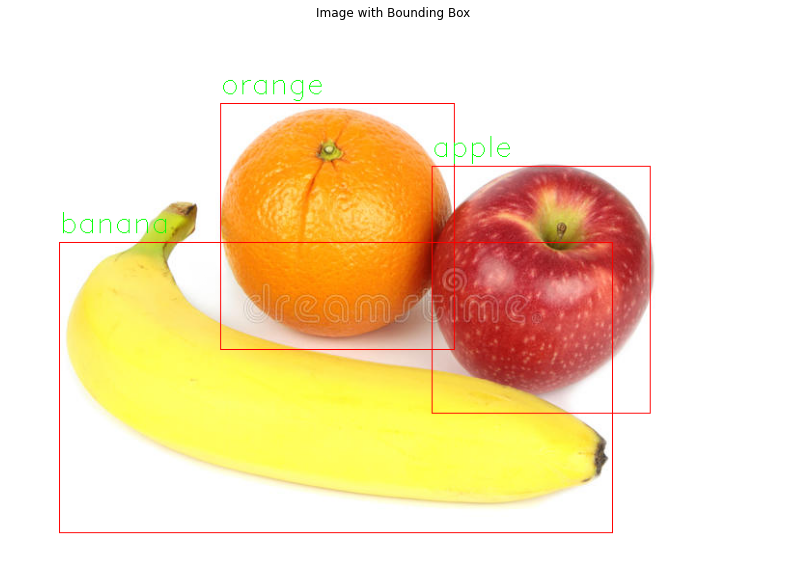

In [154]:
df = train_df
img_id = 'mixed_1'
imgname = img_id+'.jpg'
df_imgs = df[df['FileName']==imgname]
img = load_img(os.path.join(train_path,imgname), color_mode='rgb')
img = img_to_array(img)/255.
for i in range(df_imgs.shape[0]):
    df_img = df_imgs.iloc[i]
    width = img.shape[1]
    height = img.shape[0]
    xmin = df_img['XMin']
    xmax = df_img['XMax']
    ymin = df_img['YMin']
    ymax = df_img['YMax']
    class_name = df_img['ClassName']
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (1,0,0), 1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, class_name, (xmin,ymin-10), font, 1, (0,1,0), 1)
plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(img)
plt.axis("off")
plt.show()
# (xmin,xmax,ymin,ymax)

In [155]:
train_df.to_csv('train.csv')

In [160]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
    for idx, row in train_df.iterrows():
#       print(row)
        img = cv2.imread(os.path.join(train_path,row['FileName']))
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
        google_colab_file_path = train_path
        fileName = os.path.join(google_colab_file_path, row['FileName'])
        #       fileName = os.path.join(row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [165]:
test_path = 'test_zip/test'
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if name.endswith('.jpg')]
print(test_imgs)

for name_img in test_imgs:
    name = name_img[:-4]+'.xml'
    boxes, width, height, labels = extract_boxes(os.path.join(test_path,name)) 
    if width==0 or height==0:
        img = load_img(os.path.join(test_path,name_img), color_mode='rgb')
        img = img_to_array(img)
        width = img.shape[1]
        height = img.shape[0]
        print(name)
    for index in range(len(boxes)):
        test_df = test_df.append({'FileName': name_img, 
                                            'XMin': boxes[index][0]/width, 
                                            'YMin': boxes[index][1]/height, 
                                            'XMax': boxes[index][2]/width, 
                                            'YMax': boxes[index][3]/height, 
                                            'ClassName': labels[index]}, 
                                           ignore_index=True)

['apple_77.jpg', 'apple_78.jpg', 'apple_79.jpg', 'apple_80.jpg', 'apple_81.jpg', 'apple_82.jpg', 'apple_83.jpg', 'apple_84.jpg', 'apple_85.jpg', 'apple_86.jpg', 'apple_87.jpg', 'apple_88.jpg', 'apple_89.jpg', 'apple_90.jpg', 'apple_91.jpg', 'apple_92.jpg', 'apple_93.jpg', 'apple_94.jpg', 'apple_95.jpg', 'banana_77.jpg', 'banana_78.jpg', 'banana_79.jpg', 'banana_80.jpg', 'banana_81.jpg', 'banana_82.jpg', 'banana_83.jpg', 'banana_84.jpg', 'banana_85.jpg', 'banana_86.jpg', 'banana_87.jpg', 'banana_88.jpg', 'banana_89.jpg', 'banana_90.jpg', 'banana_91.jpg', 'banana_92.jpg', 'banana_93.jpg', 'banana_94.jpg', 'mixed_21.jpg', 'mixed_22.jpg', 'mixed_23.jpg', 'mixed_24.jpg', 'mixed_25.jpg', 'orange_77.jpg', 'orange_78.jpg', 'orange_79.jpg', 'orange_80.jpg', 'orange_81.jpg', 'orange_82.jpg', 'orange_83.jpg', 'orange_84.jpg', 'orange_85.jpg', 'orange_86.jpg', 'orange_87.jpg', 'orange_89.jpg', 'orange_90.jpg', 'orange_91.jpg', 'orange_92.jpg', 'orange_93.jpg', 'orange_94.jpg', 'orange_95.jpg']
app

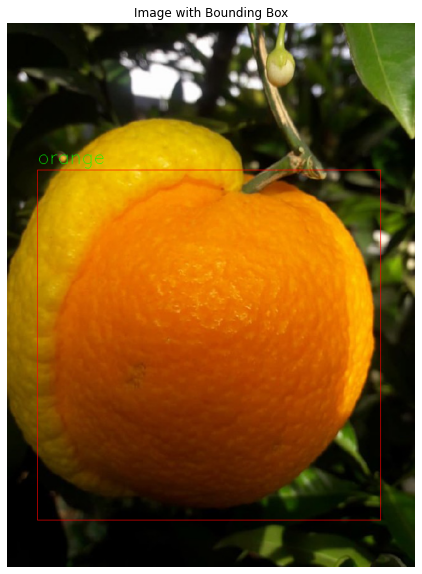

In [169]:
df = test_df
img_id = 'orange_85'
imgname = img_id+'.jpg'
df_imgs = df[df['FileName']==imgname]
img = load_img(os.path.join(test_path,imgname), color_mode='rgb')
img = img_to_array(img)/255.
for i in range(df_imgs.shape[0]):
    df_img = df_imgs.iloc[i]
    width = img.shape[1]
    height = img.shape[0]
    xmin = df_img['XMin']
    xmax = df_img['XMax']
    ymin = df_img['YMin']
    ymax = df_img['YMax']
    class_name = df_img['ClassName']
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (1,0,0), 1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, class_name, (xmin,ymin-10), font, 1, (0,1,0), 1)
plt.figure(figsize=(15,10))
plt.title('Image with Bounding Box')
plt.imshow(img)
plt.axis("off")
plt.show()


In [167]:
test_df.to_csv('test.csv')
train_df = pd.read_csv('test.csv')

# for training
with open("annotation_test.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        img = cv2.imread(os.path.join(test_path,row['FileName']))
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)

        google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
        google_colab_file_path = test_path
        fileName = os.path.join(google_colab_file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')